In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.cleanup import data

/mnt/shared/learn/OpenClassrooms/SantePubliqueFrance/src/cleanup.py:7: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("fr.openfoodfacts.org.products.csv", sep="\t")


In [2]:
data.describe()

,nutrition-score-fr_100g,additives_n,fat_100g
count,179859.000000,167355.000000,179859.000000
mean,9.163461,2.014998,13.243979
std,9.018588,2.536875,15.407974
min,-15.000000,0.000000,0.000000
25%,1.000000,0.000000,1.000000
50%,10.000000,1.000000,8.700000
75%,16.000000,3.000000,20.690000
max,40.000000,31.000000,100.000000


In [3]:
d = data.copy(deep=True)
d.loc[:,"countries"] = d['countries'].str.split(',')
d = d.explode("countries")

nutrition_by_country = d.groupby("countries")["nutrition-score-fr_100g"].mean().sort_values()
    
nutrition_by_country

countries
Vanuatu            -2.00
Oman                0.00
Gabon               0.00
Costa-Rica          1.00
Guyana              1.00
                   ...  
Aruba              19.00
Indonésie          20.00
Arabie Saoudite    22.75
Korée du Sud       23.00
Tunisie            24.00
Name: nutrition-score-fr_100g, Length: 75, dtype: float64

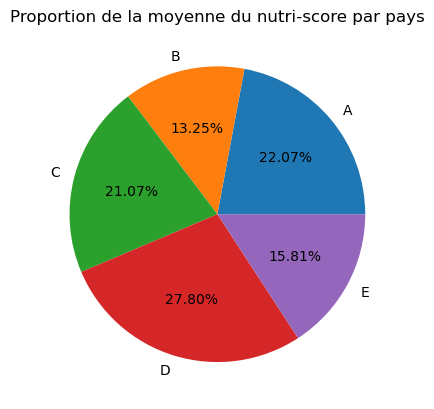

In [20]:
nutri = d["nutri_score"].value_counts().sort_index()
plt.title("Proportion de la moyenne du nutri-score par pays")
plt.pie(nutri, labels=nutri.index, autopct='%.2f%%');